In [1]:
import pymc as pm
import arviz as az

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from thesis_tools.models.frequentist import *
from thesis_tools.utils.data import *

In [3]:
df = pd.DataFrame()
df['year'] = list(range(15))
df['group'] = 'Rotterdam'
df['sigma'] = 1.0
df['constant'] = 1
df['x_2'] = np.random.normal(0, 1, len(df))
df['x_3'] = np.random.normal(0, 1, len(df))
df['epsilon'] = np.random.normal(0, 1, len(df))

const_coef = 0
x_2_coef = 1
x_3_coef = 1

for i in range(1, len(df)):
    df.loc[i, 'sigma'] = df.loc[i-1, 'sigma']*np.exp(
        const_coef * df.loc[i, 'constant'] + x_2_coef * df.loc[i, 'x_2'] + x_3_coef * df.loc[i, 'x_3'] + df.loc[i, 'epsilon']
    )

def generate_random_y(row):
    sigma = row['sigma']
    return GeneralisedPareto(gamma=0.4, sigma=sigma).sample(50)

df['y_data'] = df.apply(generate_random_y, axis=1)


In [4]:
# df = read_panel_data(observations_threshold=50)
# df = df[df['group'] == 'U.S.']

In [5]:
df

,year,group,sigma,constant,x_2,x_3,epsilon,y_data
0,0,Rotterdam,1.000000,1,1.172824,-0.786452,-0.544068,"[1.622171365586498, 1.1716332718148532, 1.3300..."
1,1,Rotterdam,0.313297,1,0.209939,-1.029365,-0.341176,"[1.1913270417369954, 1.2695892851262691, 1.009..."
2,2,Rotterdam,0.076236,1,-0.030875,-0.426074,-0.956365,"[1.0271835983561493, 1.0561884332699676, 1.051..."
3,3,Rotterdam,3.544347,1,0.779139,1.035705,2.024426,"[2.116239516890369, 9.465221925157312, 5.61758..."
4,4,Rotterdam,56.564169,1,0.379506,0.641439,1.749078,"[54.84310336763219, 11.335261429653164, 29.448..."
5,5,Rotterdam,244.352172,1,1.591709,0.410161,-0.538635,"[29.32064123439734, 192.19865959279997, 229.71..."
6,6,Rotterdam,162.198654,1,-0.001546,-1.083323,0.675081,"[106.80255419561419, 927.9239403601268, 167.84..."
7,7,Rotterdam,30.084539,1,-0.084162,-0.210941,-1.389707,"[52.671219409389565, 35.344409583666994, 12.94..."
8,8,Rotterdam,60.452997,1,1.015185,-0.044130,-0.273200,"[384.2994816255886, 15.315033772894662, 1.3858..."
9,9,Rotterdam,64.848635,1,-0.699293,0.671545,0.097938,"[138.06423306045468, 226.71101544850026, 125.4..."


In [6]:
df.columns

Index(['year', 'group', 'sigma', 'constant', 'x_2', 'x_3', 'epsilon',
       'y_data'],
      dtype='object')

In [7]:
# y_column = 'net_worth'
# covariate_names = ['constant', 'log_change_gdp_pc', 'log_change_SPX']

y_column = 'y_data'
covariate_names = ['constant', 'x_2', 'x_3']

df = df.set_index('year')

model = pm.Model()

with model:    
    betas = []
    for cov in covariate_names:
        beta_variance = pm.Gamma(f'beta_variance_{cov}', alpha=1, beta=1)
        betas.append(pm.Normal(f'beta_{cov}', mu=0, sigma=beta_variance))

    years = df.index.values
    X = df[covariate_names]

    initial_sigma = pm.Gamma(f'sigma_{years[0]}', alpha=1, beta=1) 
    sigmas = {years[0]: initial_sigma}

    epsilon_sigma = pm.Gamma('epsilon_sigma', alpha=1, beta=1)
    for year in years[1:]:
        epsilon = pm.Normal(f'epsilon_{year}', mu=0, sigma=epsilon_sigma)
        sigma = pm.Deterministic(
            f'sigma_{year}', 
            sigmas[year-1] * pm.math.exp(pm.math.dot(X.loc[year], betas) + epsilon)
        )
        sigmas[year] = sigma

    gamma_false_loc = pm.Gamma('gamma_false_loc', alpha=1, beta=1)
    gamma = pm.Deterministic('gamma', gamma_false_loc - 0.5) # From Example 2.8, Dombry, Padoan and Rizelli (2023)

    mu=1 # Mu is fixed at 1

    # Functions for the custom distribution
    def gpd_logp(value, mu, gamma, sigma):
        if gamma == 0:
            return -np.log(sigma) - (value - mu) / sigma
        else:
            return -np.log(sigma) - (1 + 1 / gamma) * np.log(1 + gamma * (value - mu) / sigma)

    def gpd_random(mu, gamma, sigma, rng=None, size=None):
        # generate uniforms
        u = rng.uniform(size=size)
        if gamma == 0:
            return mu - sigma * np.log(1-u)
        else:
            return mu + sigma * ((1 / (1 - u)**gamma - 1)) / gamma

    y_obs = []
    for year in years:
        y_obs.append(
            pm.CustomDist(
                f'y_{year}', 
                mu,
                gamma, 
                sigmas[year],
                logp=gpd_logp,
                random=gpd_random,
                observed=df.loc[year][y_column]
            )
        )

In [8]:
with model:
    trace = pm.sample(2000, tune=2000, nuts_sampler='nutpie', chains=4, cores=4, target_accept=0.975)

/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (44), generating only 20 plots
  warnings.warn(


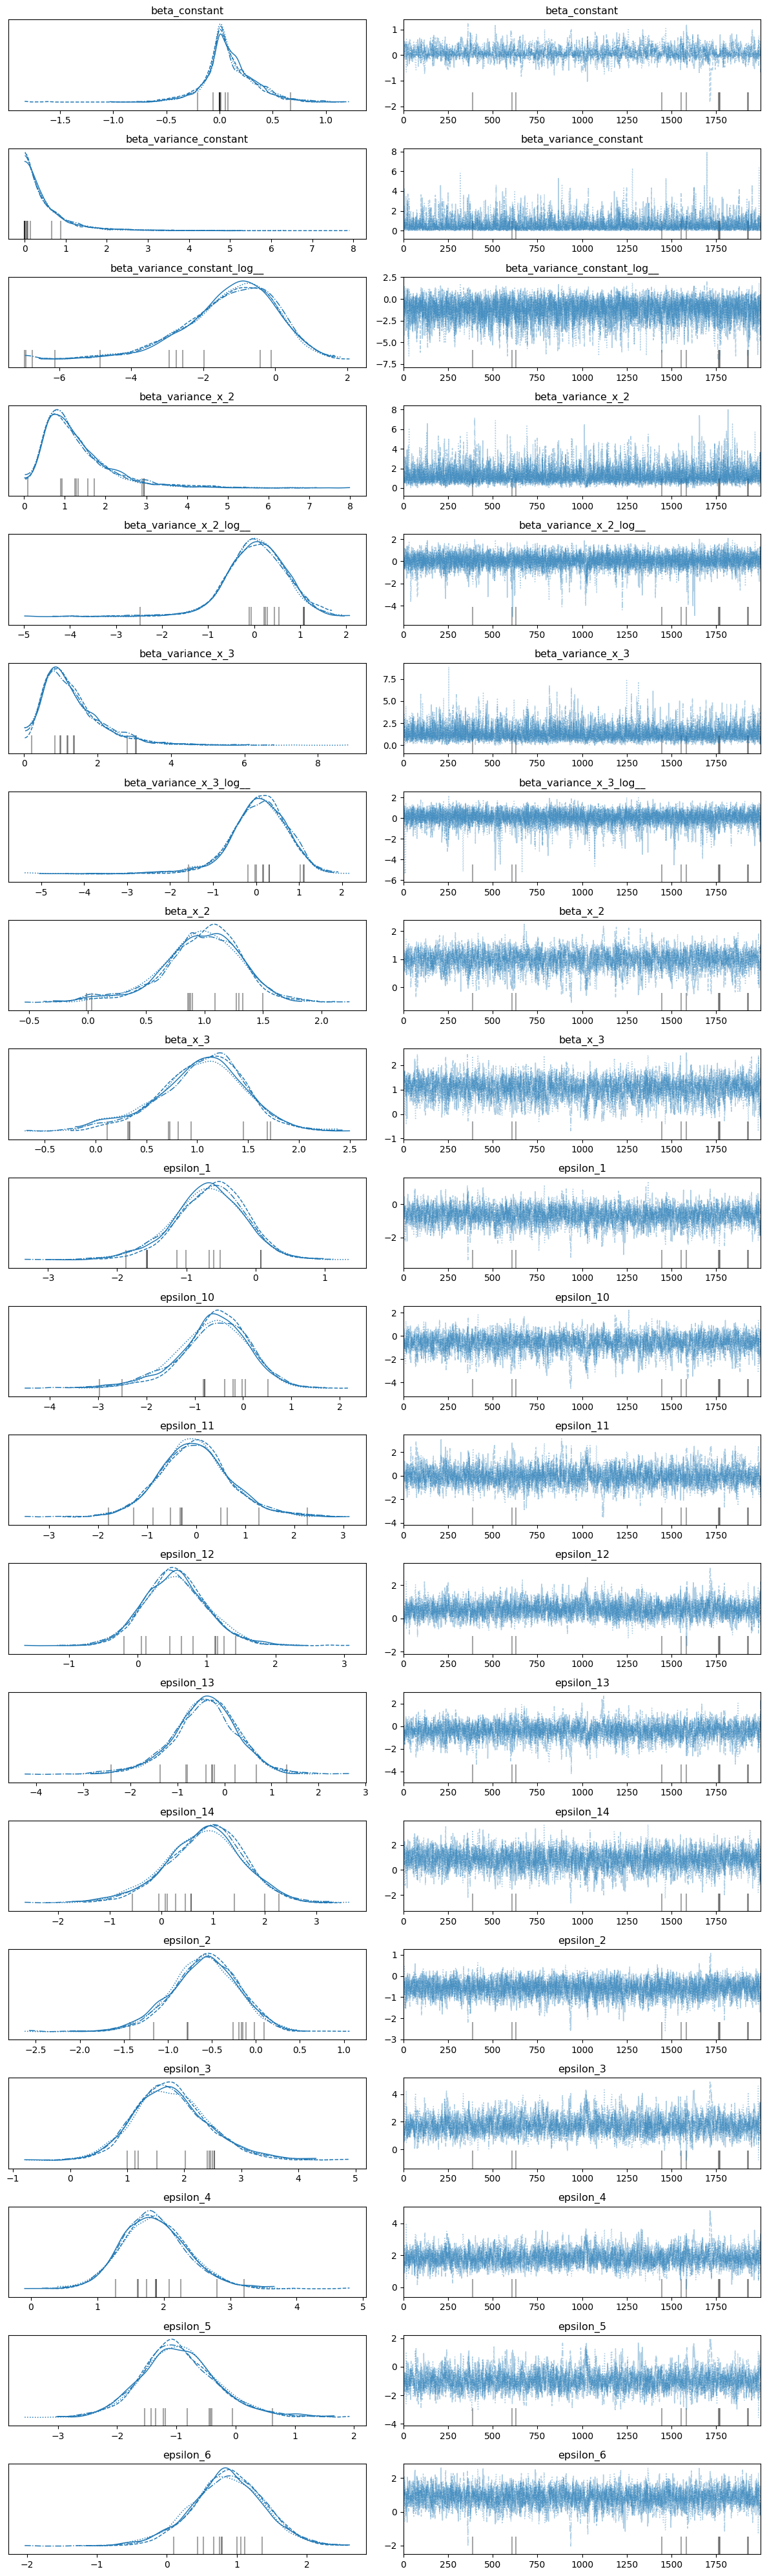

In [9]:
az.plot_trace(trace)
plt.tight_layout()

In [10]:
az.summary(trace, stat_focus='median')

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
beta_constant,0.056,0.119,-0.354,0.577,0.005,1888.747,1909.0,1.0
beta_variance_constant,0.343,0.245,0.018,2.175,0.006,4399.589,3555.0,1.0
beta_variance_constant_log__,-1.070,0.802,-4.027,0.777,0.018,4399.589,3555.0,1.0
beta_variance_x_2,1.062,0.417,0.287,3.382,0.010,6423.292,2640.0,1.0
beta_variance_x_2_log__,0.061,0.415,-1.250,1.218,0.009,6423.292,2640.0,1.0
beta_variance_x_3,1.107,0.438,0.238,3.223,0.011,5737.065,2686.0,1.0
beta_variance_x_3_log__,0.101,0.413,-1.435,1.170,0.010,5737.065,2686.0,1.0
beta_x_2,0.998,0.213,0.185,1.554,0.008,2349.015,1307.0,1.0
beta_x_3,1.073,0.269,0.111,1.794,0.010,2396.368,1931.0,1.0
epsilon_1,-0.651,0.333,-1.729,0.244,0.013,2577.612,2159.0,1.0


In [11]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [y_0, y_1, y_10, y_11, y_12, y_13, y_14, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9]


Output()